# Assignment 2
This assignment consists of two notebook files. Each exercise is graded using *hidden* tests. If you pass these tests then you are rewarded *full points* for that exercise; if your code fails the tests in any way then you will get *no points* for that exercise. Make sure to **read the rules** before you start the assignment.

## Rules
For this assignment the following rules apply:

**General**
 * The assignment should be completed in **groups of two or three** (enroll in a group on Brightspace).
 * Any kind of intergroup discussion will be considered fraud and both the parties will be punished.
 * All code must be written intra group. All external help, with the exception of Python/library documentation and the lecture slides, will be considered fraud (including generative AI).
 * Do not use libraries that implement the assignment for you. Ask a TA if you are unsure.

**Grading**
 * Each exercise is graded using additional hidden tests. These tests will check your solution for different (unseen) inputs.
 * If the tests pass without error (warnings are allowed) then you receive full points.
 * If a test cell takes more than five minutes to complete then this is considered an error.
 * Do not make any assumptions on the input data (such as resolution) unless specified otherwise. Doing so may result in the tests failing and thus 0 points.
 * Your grade is computed as $\frac{\text{points}}{\text{max\_points}} * 9 + 1$ and will be rounded to the closest 0.1 point.
 * Submit your code to Brightspace as a zip file containing only the notebook (`*.ipynb`) files.
 * **Do not rename the notebook files**
 
**Late Submissions**
 * Late submissions must be submitted *as soon as possible* to the "Assignment 2 - Late Submissions" assignment on Brightspace.
 * The following penalty will be applied: $\text{adjusted grade} = \text{grade} - 1 - \lceil\frac{\text{minutes late}}{10}\rceil$

<br />
 
**Before you submit**, make sure that you are not accidentaly using any global variables. Restart the kernel (wiping all global variables) and run the code from top to bottom by clicking "Kernel" => "Restart & Run all" in the menu bar at the top.

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.signal
import scipy.ndimage
import scipy.sparse
import os
import sys
sys.path.append("../../")
import helpers

## Exercise 0 (0 points)
This is a group assignment. Every student is expected to contribute to all exercises.

Enter the student IDs of all contributing students:

In [2]:
# YOUR CODE HERE
student_ids = ["1234", "5678" '5764440']

In [3]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL

# Image Sharpening
In this set of exercises we will create an image sharpening filter. Image sharpening is the opposite of blurring (which we as last week): the filter takes a (slightly) blurry image and makes it sharper (less blurry). In these assignments we will implement a sharpening filter to sharpen a picture that is slightly out of focus. Another common use case for image sharpening is on televisions. By default most televisions are configured to apply a sharpening filter to make the image look crisper (sometimes to the detriment of image quality).

<!-- In the Poission image editing assignments we covered how image gradients characterize an image. By only changing the colors but not the gradients we were able to create a smooth transition without changing what was in the image. Gradients are thus play an important part in encoding image information.

In the first week you learned about blur filters such as the box and Gaussian blur. A blur operation smooths edges which results in lower magnitude gradients (spread out over a larger area). The goal of image sharpening is to perform the opposite operation: reducing the "blurryness" of an image. A common application of image sharpening is in TVs and video games. Where a lower resolution image is upscaled to match the output resolution, resulting in a blurry image. -->

## Images as vectors
Last week you learned to think of images as a 2D (grayscale) or 3D (color) array of values. This week we will use only vector (1D) representations for both types of images. The idea is to store all pixels  (and color channels) in an image as a vector for computation. After the computation we convert the vector back into a 2D/3D array representation.

There are many different possible ways to convert an image into a vector. None of them are necessarily incorrect as long as we adjust our computations accordingly. However, because of the way the grading/testing system works we will use one specific way of converting to/from a vector representation: from top to bottom, and left to right.

<img src="pixel_numbering.png" alt="Pixel numbering" style="width: 25%;"/>


## Sharpening as a Linear System
*If you need a linear algebra refresher, then have a look at:*
https://www.tudelft.nl/en/eemcs/study/online-education/math-explained/linear-algebra/

As was discussed in the lectures, we can formulate an image editing operation by defining a problem as a linear system that we need to solve. In the case of image sharpening we want to make edges more well defined. We achieve this by amplifying the gradients and adjusting the colors accordingly.

Let's define $U$ as the output image vector, $\tilde{U}$ as the input image vector, $G$ as the gradient matrix and $c_s$ as the factor with which we want to scale the gradients. The gradient matrix $G$ computes a gradient vector $g$ from an image vector $U$. The gradient vector defines the gradients between the pixels of the image represented by the image vector. We define our problem as an optimization problem where the output image's colors approach the original image as closely as possible but where the gradients are amplified. We can formulate this as follows (shortening the equations by replacing $\tilde{g}=G\tilde{U}$):

$$
\begin{align}
& \underset{U}{\text{minimize}}
& & f(U) = {\lvert GU - c_s\tilde{g} \rvert}^2 + c_{\tilde{U}} {\lvert U - \tilde{U} \rvert}^2
\end{align}
$$

Here $c_{\tilde{u}}$ is a constant that scales how important it is that the output image has similar colors to the input image (relative to the importance of scaling the gradients). To find the minimum of function $f(U)$ we compute where the derivative $f'(U) = 0$. This in turn creates a linear system:
$$
\begin{align}
f(U) &= {\lvert GU - c_s\tilde{g} \rvert}^2 + c_{\tilde{U}} {\lvert U - \tilde{U} \rvert}^2 \\
     &=  U^\intercal G^\intercal GU - 2c_sU^\intercal G^\intercal \tilde{g} + {c_s}^2 \tilde{g}^\intercal \tilde{g} + c_{\tilde{U}} ({U^\intercal U + 2U^\intercal \tilde{U} + \tilde{U}^\intercal \tilde{U}}) \\
     &= U^\intercal (G^\intercal G + c_{\tilde{U}} I)U - 2U^\intercal (c_s G^\intercal \tilde{g} + c_{\tilde{U}} \tilde{U}) + {c_s}^2 \tilde{g}^\intercal \tilde{g} + c_{\tilde{U}} \tilde{U}^\intercal \tilde{U} \\
\\
f'(U) &= 2(G^\intercal G + c_{\tilde{U}} I)U - 2(c_s G^\intercal \tilde{g} + c_{\tilde{U}} \tilde{U}) \\
\end{align}
$$

$$
\begin{align}
2(G^\intercal G + c_{\tilde{U}} I)U - 2(c_s G^\intercal \tilde{g} + c_{\tilde{U}} \tilde{U}) &= 0 \\
(G^\intercal G + c_{\tilde{U}} I)U &= c_s G^\intercal \tilde{g} + c_{\tilde{U}} \tilde{U} \\
\end{align}
$$

In this formula $I$ is the identity matrix (`1` on the diagonal, `0` everywhere else) with as many rows and columns as there are pixels.


### Image Gradients
We now define gradients *between* pixels instead of at pixels. We compute the partial derivatives as follows: $g_x(x+0.5, y) = \frac{1}{2}(I(x+1, y) - I(x,y))$ and $g_y(x, y+0.5) = \frac{1}{2}(I(x, y+1) - I(x, y) )$, where $I(x, y)$ is the value of the image at pixel $(x, y)$. These are collected in a *gradient vector* which stores all partial derivatives:  $g=(g_x^0, ..., g_x^n, g_y^0, ..., g_y^m)^T$.

<!-- https://stackoverflow.com/questions/24319505/how-can-one-display-images-side-by-side-in-a-github-readme-md -->
Gradient X           |  Gradient Y
:-------------------------:|:-------------------------:
![](gradient_x.png)  |  ![](gradient_y.png)

## Exercise 1 (2 points)
Implement a function that constructs the gradient matrix for images of a given shape. Use `scipy.sparse.lil_matrix((num_rows, num_columns))` to construct a sparse matrix and convert it to a `scipy.sparse.csr_matrix` before returning it. A `lil_matrix` can be accessed just like a regular numpy array.

**WARNING**: the grading script requires the entries in the gradient *vector* to be ordered in a specific way. The gradient vector *must* contain all $g_x^i$ followed by all $g_y^i$ (so $g=(g_x^0, ..., g_x^n, g_y^0, ..., g_y^m)^T$). The $g_x$ and $g_y$ values should be ordered from left to right and from top to bottom. Make sure to use this notation in both notebooks.

In [4]:
def construct_G(width, height):
    # TODO 1: Compute the correct number of rows and columns in the gradient matrix
    
    # YOUR CODE HERE
    num_rows = width*(height - 1) + height*(width - 1) # REPLACE ME
    num_columns = width*height # REPLACE ME

    
    # Create a (num_rows x num_columns) matrix with all values set to 0.
    G = scipy.sparse.lil_matrix((num_rows, num_columns))
    # TODO 2: Fill the gradient matrix G with the correct values (0.5 and -0.5).
    # YOUR CODE HERE
    snippet = np.zeros((width - 1, width))

    for i in range(width-1):
        snippet[i][i] = -0.5
        snippet[i][i + 1] = 0.5

    for n in range(height):
        G[n*(width -1) : (n+1)*(width-1) ,n*width: (n+1)*width] = snippet

    
    for k in range(width*(height - 1)):
        G[height*(width - 1) + k, k] = 0.5
        G[height*(width - 1) + k, k + width] = - 0.5
    # Convert scipy.sparse.lil_matrix to scipy.sparse.csr_matrix for efficient processing
    return scipy.sparse.csr_matrix(G)

### Testing your solution of exercise 1
The following visualization helps you to validate whether the gradients that you have computed are correct. The $G_x$ and $G_y$ images show the horizontal and vertical derivatives (scaled by a factor of 5 for improved visibility) as computed by your gradient matrix.

Below there are a couple simple tests to verify some basic requirements.

**WARNING**: the visualization will crash if the gradient matrix does not have the correct shape!

In [5]:
# Add your own tests here.


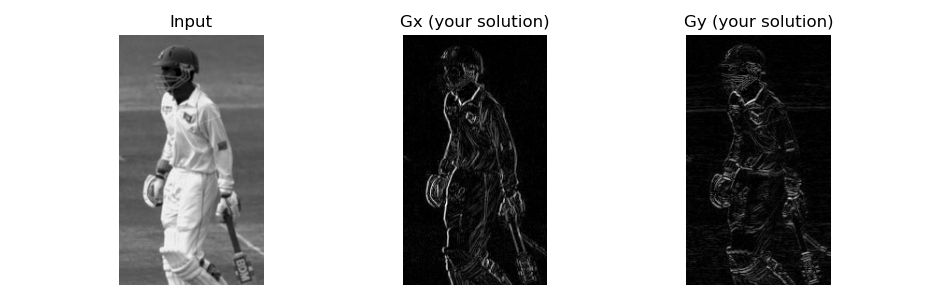

In [6]:
def construct_U(color_channel):
    # Creates image vector
    return color_channel.flatten()

def gradient_vector_to_image_gx(g, width ,height):
    out = np.zeros((height, width-1))
    
    for y in range (height):
        for x in range(width-1):
            index = y * (width - 1) + x
            out[y, x] = g[index]
            
    return out

def gradient_vector_to_image_gy(g, width ,height):
    out = np.zeros((height-1, width))
    
    num_gx = (width-1) * height
    for y in range (height-1):
        for x in range(width):
            index = num_gx + y * width + x
            out[y, x] = g[index]
            
    return out

blurry_grayscale = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week2", "image sharpening", "cricket", "cricket.png"), 0.25)
height, width = blurry_grayscale.shape

image_vector = construct_U(blurry_grayscale)
gradient_vector = construct_G(width, height) @ image_vector

gx_image = gradient_vector_to_image_gx(gradient_vector, width, height)
gy_image = gradient_vector_to_image_gy(gradient_vector, width, height)

# Increase contrast
gx_image = np.clip(np.abs(5 * gx_image), 0, 1)
gy_image = np.clip(np.abs(5 * gy_image), 0, 1)

helpers.show_images({ "Input": blurry_grayscale, "Gx (your solution)": gx_image, "Gy (your solution)": gy_image }, nrows=1, ncols=3)

In [7]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL

# Simple tests (constructing G for a 4x4 image)
G = construct_G(4, 4)

num_pixels = 16
num_gradient_components = 24
assert(G.shape == (num_gradient_components, num_pixels))
# The first horizontal gradient (between pixels 0 and 1)
assert(G[0,0] == -0.5)
assert(G[0,1] == 0.5)


## Exercise 2 (1 point)
Implement the sharpening filter as was described earlier. The function should take a (2D) image of a single color channel as input, and output a sharpened (2D) image for that color channel. This function is automatically invoked for all of the three colour channels.

Make use of `construct_U()` to convert a 2D image into an *image vector* and `construct_I()` to create an identity matrix. Use `scipy.sparse.linalg.spsolve()` ([documentation](https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html)) to solve the linear system (solve for $\vec{x}$ in $A\vec{x}=\vec{b}$).

**NOTE**: For grading we use the reference implementation of `construct_G()` to ensure that you are not punished for mistakes in the previous exercise.

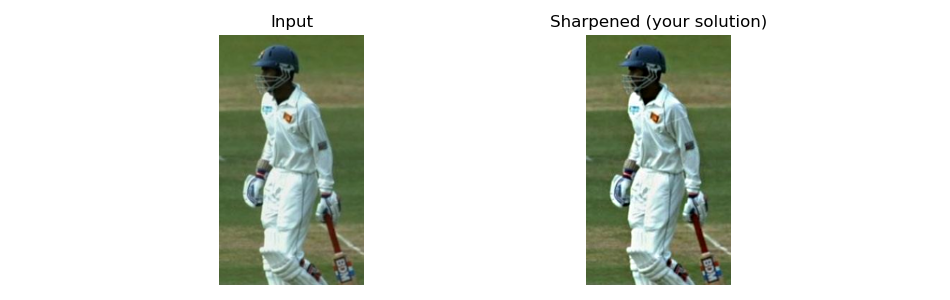

In [8]:
# Constructs a (n x n) identity matrix
def construct_I(n):
    I = scipy.sparse.lil_matrix((n, n))
    I.setdiag(1)
    return scipy.sparse.csr_matrix(I)

def sharpen_color_channel(image, cs, cu):
    # TODO: Perform sharpening as described in the exercise description.
    # YOUR CODE HERE
    height, width = image.shape
    image_vector = construct_U(image)

    A = construct_G(width, height).T @ construct_G(width, height) + cu * construct_I(width * height)
    b = cs * construct_G(width, height).T @ construct_G(width, height) @ image_vector + cu * image_vector

    U = scipy.sparse.linalg.spsolve(A,b)
    image = np.reshape(U, (height, width))
    return image.copy()
    
def sharpen_image(image, cs, cu):
    red_channel = sharpen_color_channel(image[:,:,0], cs, cu)
    green_channel = sharpen_color_channel(image[:,:,1], cs, cu)
    blue_channel = sharpen_color_channel(image[:,:,2], cs, cu)
    return np.stack([red_channel, green_channel, blue_channel], axis=2)
    
blurry_rgb = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "image sharpening", "cricket", "cricket.png"), 0.25)
sharpened_rgb = np.clip(sharpen_image(blurry_rgb, 1.3, 0.01), 0, 1)

helpers.show_images({ "Input": blurry_rgb, "Sharpened (your solution)": sharpened_rgb }, nrows=1, ncols=2)

### Testing your solution of exercise 2
The sharpening filter should make the image sharper by increasing the gradient magnitudes by $30\%$. However, due to the color restraints (matching the input image) the actual increase in gradient magnitude will be smaller (around $25\%$).

In [9]:
# Add your own tests here.

Mean gradient magnitudes:
Original Image:    0.1535
Your Result Image: 0.1912 (1.25x)


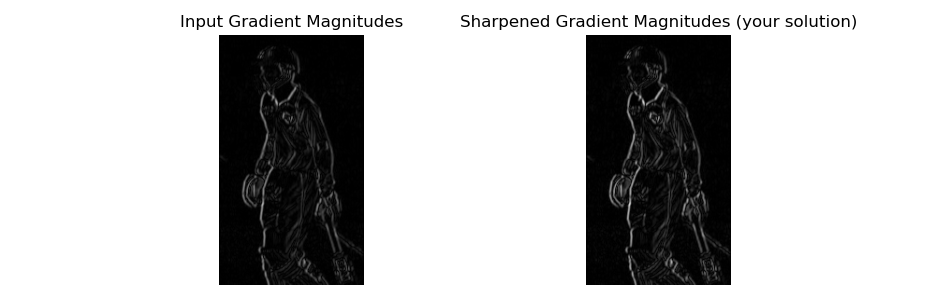

In [10]:
blurry_rgb = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "image sharpening", "cricket", "cricket.png"), 0.25)
sharpened_rgb = np.clip(sharpen_image(blurry_rgb, 1.3, 0.01), 0, 1)

input_gradient_magnitudes = np.abs(scipy.ndimage.sobel(helpers.rgb2gray(blurry_rgb)))
sharpened_gradient_magnitudes = np.abs(scipy.ndimage.sobel(helpers.rgb2gray(sharpened_rgb)))

mean_input_gradient_magnitude = np.mean(input_gradient_magnitudes)
mean_sharpened_gradient_magnitude = np.mean(sharpened_gradient_magnitudes)

print("Mean gradient magnitudes:")
print(f"Original Image:    {mean_input_gradient_magnitude:.4f}")
print(f"Your Result Image: {mean_sharpened_gradient_magnitude:.4f} ({mean_sharpened_gradient_magnitude/mean_input_gradient_magnitude:.2f}x)")

helpers.show_images({
    "Input Gradient Magnitudes": input_gradient_magnitudes / 4,
    "Sharpened Gradient Magnitudes (your solution)": sharpened_gradient_magnitudes / 4
}, nrows=1, ncols=2)

In [11]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL
